**IMPORTS**

In [ ]:
from google.colab import drive
import re
import time
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import string
import random
from collections import defaultdict
import copy

!pip install OpenAI
import openai

**CONECTION TO GOOGLE DRIVE**

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/NL2CNL'

**PROCESSING EXCEL FILE**

In [ ]:
# EXTRACTING THE DATA FROM EXCEL AND CREATING A PYTHON LIST WITH OBJECTS = {ASP, CNL, NL, TCNL, TNL} Optimized Unique Temp.
excel = pandas.read_excel(os.path.join(data_path, "Master_File_1.xlsx"), "Optimized Unique Temp.")

def isNaN(string):
    return string != string
rows = []
removed = []
for index, r in excel.iterrows():
  row = {'asp' : r["ASP"] if not isNaN( r["ASP"]) else ''}
  row['cnl'] =  r["CNL"] if not isNaN( r["CNL"]) else ''
  row['nl'] =  r["Natural Language"] if not isNaN( r["Natural Language"]) else ''
  row['tcnl'] =  r["Template CNL"] if not isNaN( r["Template CNL"]) else ''
  row['tnl'] =  r["Template NL"] if not isNaN( r["Template NL"]) else ''
  rows.append(row)
print('ROWS length >>>: ', len(rows))

r_copy = rows.copy()
for idx in range(len(rows)):
  if(r_copy[idx]['cnl'].strip() == '' or r_copy[idx]['asp'].strip() == '' or r_copy[idx]['nl'].strip() == '' or r_copy[idx]['tcnl'].strip() == '' or r_copy[idx]['tnl'].strip() == ''):
    removed.append(r_copy[idx])
    rows.pop(idx)
print('ROWS length after clean >>>: ', len(rows))
removed

ROWS length >>>:  370
ROWS length after clean >>>:  369


[{'asp': ' :- not [ adjacent(U,V,X,Y) : u_edge(U,V,W) = W ] E, edgebound(E), parts(X,Y), X < Y.',
  'cnl': '',
  'nl': '',
  'tcnl': '',
  'tnl': ''}]

In [ ]:
# ////CHECK THAT TCNL AND CNL MATCH/////////
problematics = []
for idx, row in enumerate(rows):
  cnl =  re.sub('\s+', ' ', row['cnl'])
  tcnl = re.sub('\s+', ' ', row['tcnl'])
  if(cnl.strip().split()[0] != tcnl.strip().split()[0] and (not tcnl.strip().split()[0].startswith('noun') and not tcnl.strip().split()[0].startswith('num') and not tcnl.strip().split()[0].startswith('var'))):
    problematics.append(row)
problematics

In [ ]:
# EXTRACTING THE DATA FROM EXCEL CORRESPONDING TO THE ORIGINAL DATASET
original_excel = pandas.read_excel(os.path.join(data_path, "Master_File_1.xlsx"), "Templates_Duplicate_Remove")

def isNaN(string):
    return string != string
original_rows = []
for index, r in original_excel.iterrows():
  row = {'asp' : r["ASP"] if not isNaN( r["ASP"]) else ''}
  row['cnl'] =  r["CNL"] if not isNaN( r["CNL"]) else ''
  row['nl'] =  r["Natural Language"] if not isNaN( r["Natural Language"]) else ''
  row['tcnl'] =  r["Template CNL"] if not isNaN( r["Template CNL"]) else ''
  row['tnl'] =  r["Template NL"] if not isNaN( r["Template NL"]) else ''
  original_rows.append(row)

counts = {}
for r in original_rows:
  sent = re.sub('\s+', ' ', r['nl'].strip().lower())
  if sent not in counts:
    counts[sent] = 1
  else:
    counts[sent] += 1

for c in counts:
  if counts[c] > 1:
    print(c, ' ---------> ', counts[c])

**PLOTTING THE DATASET INFORMATION**

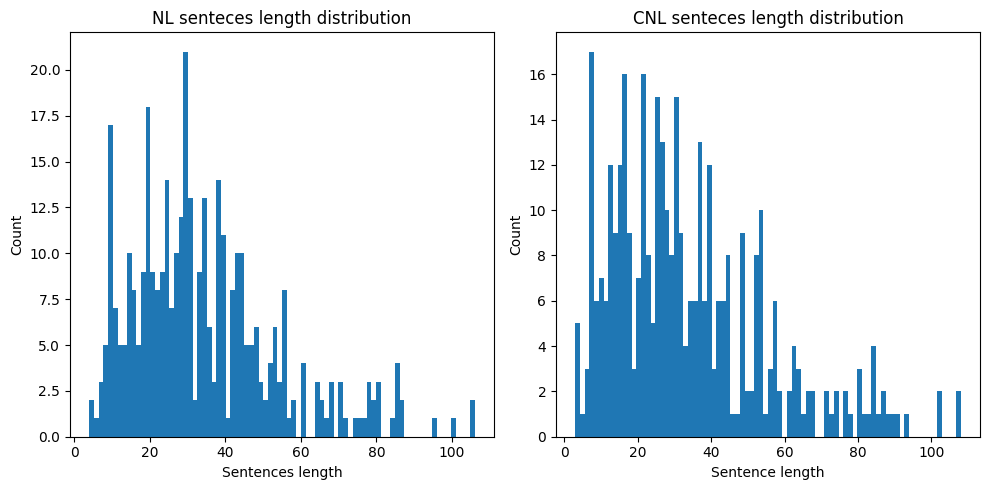

In [ ]:
# PLOTTING THE NL AND CNL SENTENCES LENGTH DISTRIBUTIONS
nl_lengths = [len(row['nl'].split()) for row in rows]
cnl_lengths = [len(row['cnl'].split()) for row in rows]

# /////CALCULATING THE NUMBER OF BINS/////
counts_nl = {}
counts_cnl = {}
for c in nl_lengths:
  if str(c) not in counts_nl:
    counts_nl[str(c)] = 1
  else:
    counts_nl[str(c)] = counts_nl[str(c)] + 1
for c in cnl_lengths:
  if str(c) not in counts_cnl:
    counts_cnl[str(c)] = 1
  else:
    counts_cnl[str(c)] = counts_cnl[str(c)] + 1

fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(10, 5))
a = axs[0].hist(nl_lengths, bins=len(counts_cnl))
_ = axs[0].set_xlabel("Sentences length")
_ = axs[0].set_ylabel("Count")
_ = axs[0].set_title("NL senteces length distribution")

b = axs[1].hist(cnl_lengths, bins=len(counts_cnl))
_ = axs[1].set_xlabel("Sentence length")
_ = axs[1].set_ylabel("Count")
_ = axs[1].set_title("CNL senteces length distribution")


In [ ]:
#COUNTING CNL PROPOSITIONS BY TYPE AND KEEPING THE INDEXES OF THE PROPOSITIONS IN THE LIST
count_cnl_by_type = {
  'Negative Strong Constraint':0,
  'Positive Strong Constraint':0,
  'Weak Constraint':0 ,
  'Definition Whenever':0,
  'Definition When':0,
  'Definition Const/Compound':0,
  'Quantified Choice Rules':0
}
negative_indexes = []
positive_indexes = []
weak_indexes = []
choice_indexes = []
whenever_indexes = []
when_indexes = []
other_def_indexes = []
for idx, row in enumerate(rows):
  cnl_lower = row['cnl'].lower().strip()
  asp_lower = row['asp'].lower().strip()
  if 'it is prohibited' in cnl_lower:
    count_cnl_by_type['Negative Strong Constraint'] += 1
    negative_indexes.append(idx)
  elif 'it is required' in cnl_lower:
    count_cnl_by_type['Positive Strong Constraint'] += 1
    positive_indexes.append(idx)
  elif 'it is preferred' in cnl_lower:
    count_cnl_by_type['Weak Constraint'] += 1
    weak_indexes.append(idx)
  elif re.match(r'^\d*\s{0,1}\{.*\}', asp_lower) and '#maximize' not in asp_lower and '#minimize' not in asp_lower:
    count_cnl_by_type['Quantified Choice Rules'] += 1
    choice_indexes.append(idx)
  elif cnl_lower.startswith('whenever'):
    count_cnl_by_type['Definition Whenever'] += 1
    whenever_indexes.append(idx)
  elif re.match(r'.*\swhen\s.*$', cnl_lower):
    count_cnl_by_type['Definition When'] += 1
    when_indexes.append(idx)
  else:
     count_cnl_by_type['Definition Const/Compound'] += 1
     other_def_indexes.append(idx)
count_cnl_by_type

{'Negative Strong Constraint': 21,
 'Positive Strong Constraint': 37,
 'Weak Constraint': 11,
 'Definition Whenever': 106,
 'Definition When': 136,
 'Definition Const/Compound': 46,
 'Quantified Choice Rules': 12}

In [ ]:
#COUNTING CNL PROPOSITIONS BY TYPE AND KEEPING THE INDEXES OF THE PROPOSITIONS IN THE ORIGINAL LIST (NO CLEAN)
ori_negative_indexes = []
ori_positive_indexes = []
ori_weak_indexes = []
ori_choice_indexes = []
ori_whenever_indexes = []
ori_when_indexes = []
ori_other_def_indexes = []
for idx, row in enumerate(original_rows):
  cnl_lower = row['cnl'].lower().strip()
  asp_lower = row['asp'].lower().strip()
  if 'it is prohibited' in cnl_lower:
    ori_negative_indexes.append(idx)
  elif 'it is required' in cnl_lower:
    ori_positive_indexes.append(idx)
  elif 'it is preferred' in cnl_lower:
    ori_weak_indexes.append(idx)
  elif re.match(r'^\d*\s{0,1}\{.*\}', asp_lower) and '#maximize' not in asp_lower and '#minimize' not in asp_lower:
    ori_choice_indexes.append(idx)
  elif cnl_lower.startswith('whenever'):
    ori_whenever_indexes.append(idx)
  elif re.match(r'.*\swhen\s.*$', cnl_lower):
    ori_when_indexes.append(idx)
  else:
     ori_other_def_indexes.append(idx)
ori_other_def_indexes

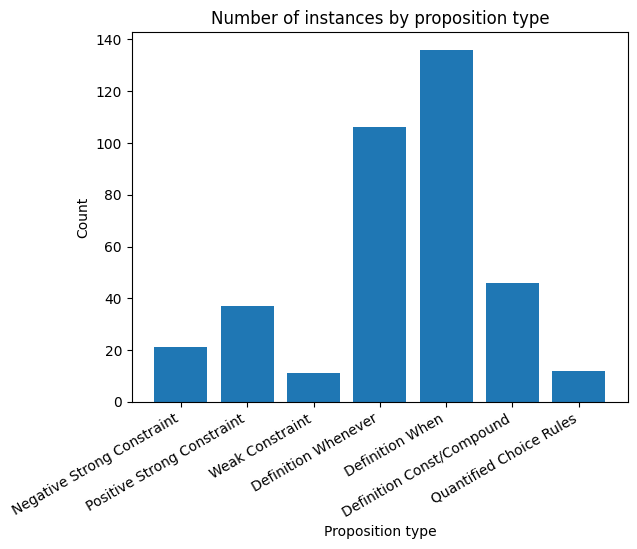

In [ ]:
# /////Plotting Number of instances by proposition type/////
counts_nl = {}
counts_cnl = {}
for c in nl_lengths:
  if str(c) not in counts_nl:
    counts_nl[str(c)] = 1
  else:
    counts_nl[str(c)] = counts_nl[str(c)] + 1
for c in cnl_lengths:
  if str(c) not in counts_cnl:
    counts_cnl[str(c)] = 1
  else:
    counts_cnl[str(c)] = counts_cnl[str(c)] + 1

_ = plt.bar(list(count_cnl_by_type.keys()), list(count_cnl_by_type.values()), width=0.8)
_ = plt.xticks(rotation=30, ha='right')
_ = plt.title("Number of instances by proposition type")
_ = plt.ylabel("Count")
_ = plt.xlabel("Proposition type")

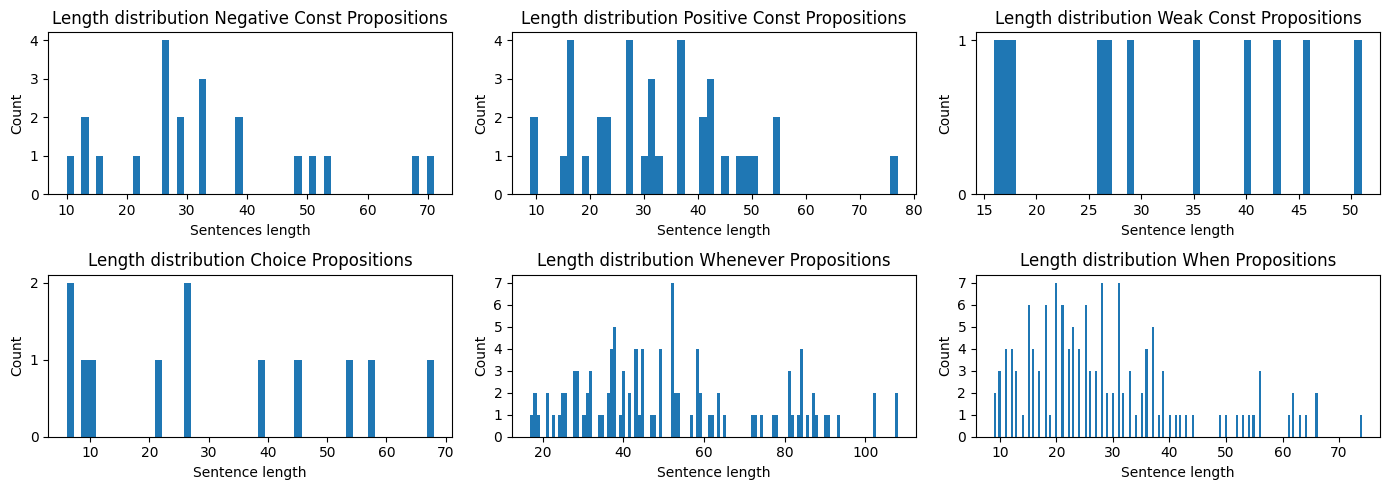

In [ ]:
# /////SOME OTHER PLOTS/////
from zmq.constants import XPUB_VERBOSE
# /////INSTANCES LENGHT BY TYPE/////
neg_lengths = np.take(cnl_lengths, negative_indexes)
pos_lengths = np.take(cnl_lengths, positive_indexes)
weak_lengths = np.take(cnl_lengths, weak_indexes)
choice_lengths = np.take(cnl_lengths, choice_indexes)
whenever_lengths = np.take(cnl_lengths, whenever_indexes)
when_lengths = np.take(cnl_lengths, when_indexes)
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(14, 5))

xs = axs[0][0].hist(neg_lengths, bins=50)
yint = range(0, int(max(set(xs[0])))+1, 1)
_ = axs[0][0].set_xlabel("Sentences length")
_ = axs[0][0].set_ylabel("Count")
_ = axs[0][0].set_title("Length distribution Negative Const Propositions")
_ = axs[0][0].set_yticks(yint)

xs = axs[0][1].hist(pos_lengths, bins=50)
yint = range(0, int(max(set(xs[0])))+1, 1)
_ = axs[0][1].set_xlabel("Sentence length")
_ = axs[0][1].set_ylabel("Count")
_ = axs[0][1].set_title("Length distribution Positive Const Propositions")
_ = axs[0][1].set_yticks(yint)

xs = axs[0][2].hist(weak_lengths, bins=50)
yint = range(0, int(max(set(xs[0])))+1, 1)
_ = axs[0][2].set_xlabel("Sentence length")
_ = axs[0][2].set_ylabel("Count")
_ = axs[0][2].set_title("Length distribution Weak Const Propositions")
_ = axs[0][2].set_yticks(yint)

xs = axs[1][0].hist(choice_lengths, bins=50)
yint = range(0, int(max(set(xs[0])))+1, 1)
_ = axs[1][0].set_xlabel("Sentence length")
_ = axs[1][0].set_ylabel("Count")
_ = axs[1][0].set_title("Length distribution Choice Propositions")
_ = axs[1][0].set_yticks(yint)

xs = axs[1][1].hist(whenever_lengths, bins=120)
yint = range(0, int(max(set(xs[0])))+1, 1)
_ = axs[1][1].set_xlabel("Sentence length")
_ = axs[1][1].set_ylabel("Count")
_ = axs[1][1].set_title("Length distribution Whenever Propositions")
_ = axs[1][1].set_yticks(yint)

xs = axs[1][2].hist(when_lengths, bins=175)
yint = range(0, int(max(set(xs[0])))+1, 1)
_ = axs[1][2].set_xlabel("Sentence length")
_ = axs[1][2].set_ylabel("Count")
_ = axs[1][2].set_title("Length distribution When Propositions")
_ = axs[1][2].set_yticks(yint)


In [ ]:
# /////ANALYSIS OF OUTLIERS/////
'''
pre_type is one of the following
  'Negative Strong Constraint'
  'Positive Strong Constraint'
  'Weak Constraint'
  'Definition Whenever'
  'Definition When'
  'Definition Const/Compound'
  'Quantified Choice Rules'
  '''
def print_outliers_prepositions(pre_type, threshold=100):
  indexes = []
  if pre_type == 'Negative Strong Constraint':
    indexes = negative_indexes
  elif pre_type == 'Positive Strong Constraint':
    indexes = positive_indexes
  elif pre_type == 'Weak Constraint':
    indexes = weak_indexes
  elif pre_type == 'Definition Whenever':
    indexes = whenever_indexes
  elif pre_type == 'Definition When':
    indexes = when_indexes
  elif pre_type == 'Quantified Choice Rules':
    indexes = choice_indexes
  else:
    indexes = other_def_indexes

  lengths = np.take(cnl_lengths, indexes)
  for idx, l in enumerate(lengths):
    if l > threshold:
      print('index: ', indexes[idx], ' length: ', l, ' sentence: ', rows[indexes[idx]]['cnl'])

print_outliers_prepositions('Definition Whenever', 100)


index:  278  length:  102  sentence:  whenever there is a edge with value U, with id V, whenever there is a active with key W, whenever there is not a trivial with value V,  whenever there is not a trivial with value W, whenever there is a active with key V, whenever there is a reach with field1 V, and with field2 W different from V, whenever there is a reach with field1 W, and with field2 V, whenever there is not a mvlabel with field1 W, with field2 V, with field3 M, then there must be a mvlabel with field1 W, with field2 V, with field3 P.
index:  279  length:  102  sentence:  whenever there is a edge with value U, with id V, whenever there is a active with key W, whenever there is not a trivial with value V,  whenever there is not a trivial with value W, whenever there is a active with key V, whenever there is a reach with field1 V, and with field2 W different from V, whenever there is a reach with field1 W, and with field2 V, whenever there is not a mvlabel with field1 W, with field

**DATASET GENERATION**

**Support Functions**

In [ ]:
# ////Integer/Integer-Interval generators////
# ///This functions allow to generate the integers and range of integet to be used in the placeholder replacement///
import random
def generate_random_integer(start=1, end=50):
  return random.randrange(start, end)

def generate_random_interval(min=1, max=100):
  start = generate_random_integer(min, max)
  end = generate_random_integer(1, max-start+1)
  while start+end > max:
    end = generate_random_integer(1, max-start+1)
  return [start, end+start]

generate_random_interval()

**Balanced Dataset Generation**


In [ ]:
'''
{
  verbs: list,
  nouns: list,
  pid: list
}
'''

def generate_replacements(bow, cnl_template, nl_template):
    # Combine CNL and NL templates for extracting placeholders
    template = cnl_template + nl_template

    replacements = {}

    # Replacing verb_X placeholders with appropriate values
    verb_placeholders = re.findall(r'\bverb_\d+', template)
    verb_placeholders = set(verb_placeholders)
    useds = []
    print('---Replacing verbs---')
    for placeholder in verb_placeholders:
        choice = random.choice(bow['verbs'])
        while choice in useds:
          choice = random.choice(bow['verbs'])
        replacements[placeholder] = choice
        useds.append(choice)

    # Replacing noun_X placeholders with appropriate values
    noun_placeholders = re.findall(r'\bnoun_\d+', template)
    noun_placeholders = set(noun_placeholders)
    useds = []
    print('---Replacing nouns---')
    for placeholder in noun_placeholders:
        choice = random.choice(bow['nouns'])
        while choice in useds:
          choice =  random.choice(bow['nouns'])
        replacements[placeholder] = choice
        useds.append(choice)

    # Replacing var_X placeholders with appropriate values
    var_placeholders = re.findall(r'\bvar_\d+', template)
    var_placeholders = set(var_placeholders)
    useds = []
    print('---Replacing variables---')
    for placeholder in var_placeholders:
        choice = random.choice(string.ascii_uppercase)
        while choice in useds:
          choice = random.choice(string.ascii_uppercase)
        replacements[placeholder] = choice
        useds.append(choice)

    # Replacing col_X placeholders with appropriate values
    col_placeholders = re.findall(r'\bcol_\d+', template)
    useds = []
    print('---Replacing colors---')
    for placeholder in col_placeholders:
        choice = random.choice(['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black'])
        while choice in useds:
          choice = random.choice(['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black'])
        replacements[placeholder] = choice
        useds.append(choice)

    # Replacing num_X placeholders with appropriate values
    num_placeholders = re.findall(r'\bnum_\d+', template)
    num_placeholders = set(num_placeholders)
    print('---Replacing numbers---')
    for i, placeholder in enumerate(sorted(num_placeholders)):
        replacements[placeholder] = generate_random_integer()

    # Replace num_range placeholders with appropriate values
    num_range_placeholders = re.findall(r'\bnum_range\b', template)
    num_range_placeholders = set(num_range_placeholders)
    print('---Replacing number ranges---')
    for placeholder in num_range_placeholders:
        interval = generate_random_interval()
        replacements[placeholder] = f'{interval[0]} to {interval[1]}'

    # Replace num_choice placeholders with appropriate values
    num_choice_placeholders = re.findall(r'\bnum_choice\b', template)
    print('---Replacing number choice constructs---')
    for placeholder in num_choice_placeholders:
        num_list = [generate_random_integer(1, 30) for _ in range(random.randint(2, 10))]
        num_list = sorted(list(set(num_list)))
        replacements[placeholder] = ', '.join(map(str, num_list))

    # Replace PID_X placeholders with appropriate values
    pid_placeholders = re.findall(r'\bPID_\d+', template)
    pid_placeholders = set(pid_placeholders)
    useds = []
    print('---Replacing identifiers---')
    for placeholder in pid_placeholders:
        choice = random.choice(bow['pid'])
        while choice in useds:
          choice = random.choice(bow['pid'])
        replacements[placeholder] = choice
        useds.append(choice)
    return replacements


def fill_template(template, replacements):
    filled_template = template
    for placeholder, value in replacements.items():
        # Convert the value to string if it's an integer
        if isinstance(value, int):
            value = str(value)
        filled_template = filled_template.replace(placeholder, value)
    return filled_template


# Loading predefined words from files
verbs_df = pandas.read_excel('/content/drive/MyDrive/NL2CNL/verbs.xlsx')  # Excel file containing verbs
nouns_df = pandas.read_excel('/content/drive/MyDrive/NL2CNL/nouns.xlsx')  # Excel file containing nouns
pid_df = pandas.read_excel('/content/drive/MyDrive/NL2CNL/pid.xlsx')  # Excel file containing pid

# Extract verbs and nouns from dataframes
verbs = verbs_df['Verb'].tolist()
nouns = nouns_df['Noun'].tolist()
pid = pid_df['PID'].tolist()

# Bag of Words
bow = {'nouns': nouns, 'verbs': verbs, 'pid': pid}

# Set the target number of instances for each category
target_count = 180

# # Initialize a dictionary to store the balanced dataset
balanced_rows = defaultdict(list)

# ////Adding the former NL and CNL to the temporal list
generateds_tmp = [re.sub(' +', ' ', row['nl']).strip().lower() for row in original_rows] + [re.sub(' +', ' ', row['cnl']).strip().lower() for row in original_rows]

# GENERATING AND BALANCING THE DATASET

# number of instances by preposition type in the handmade dataset
former_count_by_preps = {'Negative Strong Constraint': 22,
                         'Positive Strong Constraint': 39,
                         'Weak Constraint': 11,
                         'Definition Whenever': 119,
                         'Definition When': 145,
                         'Definition Const/Compound': 154,
                         'Quantified Choice Rules': 4}


cat_idx_pairs = zip(['Negative Strong Constraint', 'Positive Strong Constraint', 'Weak Constraint',
                                'Definition Whenever', 'Definition When', 'Quantified Choice Rules'],
                              [negative_indexes, positive_indexes, weak_indexes, whenever_indexes, when_indexes, choice_indexes])
max_count = 160
for category, indexes in cat_idx_pairs:
    count = 0
    target_count = max_count - former_count_by_preps[category]
    # /////Make at this point the checkings to avoid repetition
    while count < target_count:
    # while count < target_count:
        index = random.choice(indexes)

        row = rows[index]
        tcnl = row['tcnl']
        tnl = row['tnl']

        replacements = generate_replacements(bow, tcnl, tnl)
        filled_cnl = fill_template(tcnl, replacements)
        filled_nl = fill_template(tnl, replacements)

        # If the generated sentences already exists, then generate skip it (Avoiding duplicates)
        if filled_cnl.strip().lower() not in generateds_tmp and filled_nl.strip().lower() not in generateds_tmp:
          # Append the filled templates to the balanced dataset
          balanced_rows[category].append({'CNL': filled_cnl, 'NL': filled_nl, 'TCNL': tcnl, 'TNL': tnl, 'ASP': row['asp'], 'Generated': True})
          generateds_tmp.append(re.sub(' +', ' ', filled_cnl).strip().lower())
          generateds_tmp.append(re.sub(' +', ' ', filled_nl).strip().lower())
          count += 1

# ///Generation of Specifice Categories, to create the balance dataset.
former_count_by_preps = {'Definition Const/Compound': 154, 'Quantified Choice Rules': 4}
cat_idx_pairs = zip(['Definition Const/Compound'], [other_def_indexes])
for category, indexes in cat_idx_pairs:
    count = 0
    seq_idx = 0
    target_count = max_count - former_count_by_preps[category]
    # /////Make at this point the checkings to avoid repetition
    while count < target_count:
    # while count < target_count:
        if(seq_idx ==len(other_def_indexes)):
          seq_idx = 0
        index = indexes[seq_idx]
        row = rows[index]

        tcnl = row['tcnl']
        tnl = row['tnl']
        replacements = generate_replacements(bow, tcnl, tnl)

        filled_cnl = fill_template(tcnl, replacements)
        filled_nl = fill_template(tnl, replacements)

        # If the generated sentences already exists, then generate skip it (Avoiding duplicates)
        if filled_cnl.strip().lower() not in generateds_tmp and filled_nl.strip().lower() not in generateds_tmp:
          # Append the filled templates to the balanced dataset
          balanced_rows[category].append({'CNL': filled_cnl, 'NL': filled_nl, 'TCNL': tcnl, 'TNL': tnl, 'ASP': row['asp'], 'Generated': True})
          generateds_tmp.append(re.sub(' +', ' ', filled_cnl).strip().lower())
          generateds_tmp.append(re.sub(' +', ' ', filled_nl).strip().lower())
          count += 1
        seq_idx+=1

# //////creating some extra "goes from"/////
count = 0
while count < 15:
    tcnl = 'A noun_1 goes from num_range.'
    tnl = 'Assume that there are num_range noun_1 in a graph.'
    asp = 'vtx(1..4).'
    replacements = generate_replacements(bow, tcnl, tnl)

    filled_cnl = fill_template(tcnl, replacements)
    filled_nl = fill_template(tnl, replacements)

    # If the generated sentences already exists, then generate them again (Avoiding duplicates)
    if filled_cnl.strip().lower() not in generateds_tmp and filled_nl.strip().lower() not in generateds_tmp:
      # Append the filled templates to the balanced dataset
      balanced_rows[category].append({'CNL': filled_cnl, 'NL': filled_nl, 'TCNL': tcnl, 'TNL': tnl, 'ASP': asp, 'Generated': True})
      generateds_tmp.append(re.sub(' +', ' ', filled_cnl).strip().lower())
      generateds_tmp.append(re.sub(' +', ' ', filled_nl).strip().lower())
      count += 1
# /////////////////////////////////////////////////////////////////////////////////////////////////

# Convert the balanced dataset to a pandas DataFrame and save it as a CSV file
balanced_data = []
for category, rows in balanced_rows.items():
    for row in rows:
        balanced_data.append({'Category': category, 'CNL': row['CNL'], 'NL': row['NL'], 'TCNL': row['TCNL'], 'TNL':  row['TNL'], 'ASP': row['ASP'], 'Generated': True})


# # Combine original dataset the balanced dataset to a pandas DataFrame and save it as a CSV file
ori_cat_idx_pairs = zip(['Negative Strong Constraint', 'Positive Strong Constraint', 'Weak Constraint',
                                'Definition Whenever', 'Definition When', 'Definition Const/Compound',
                                'Quantified Choice Rules'],
                              [ori_negative_indexes, ori_positive_indexes, ori_weak_indexes, ori_whenever_indexes, ori_when_indexes, ori_other_def_indexes, ori_choice_indexes])

for category, indexes in ori_cat_idx_pairs:
  for idx in indexes:
    balanced_data.append({'Category': category, 'CNL': original_rows[idx]['cnl'], 'NL': original_rows[idx]['nl'], 'TCNL': original_rows[idx]['tcnl'],
                          'TNL':  original_rows[idx]['tnl'], 'ASP': original_rows[idx]['asp'], 'Generated': False})


# //////FIXING HAVE/HAS - THERE IS - THERE SHOULD BE//////
def fix_syntax_has_have(sentence, reg_exp='(have|has)\s+(an|a)\s+[^\s]+', casual=False):
  matches = re.finditer(reg_exp, sentence)
  nl = sentence
  for mtch in matches:
    do_replace = True if casual==False else bool(random.getrandbits(1))
    spl = mtch.group(0).split()
    rpl = ''
    if do_replace:
      if spl[2][0] in ["a", "e", "i", "o", "u", "A", "E", "I", "O", "U"]:
        rpl = 'has an ' + spl[2]
      else:
        rpl = 'has a ' + spl[2]
      nl = nl.replace(mtch.group(0), rpl)
      nl = nl.replace('then we must has', 'then we must have')
      nl = nl.replace('that there will not has', 'that there will not have')
      nl = nl.replace('to has', 'to have')
  return nl

def fix_syntax_there_is(sentence, reg_exp='(there is)\s+(an|a)\s+[^\s]+', casual=False):
  matches = re.finditer(reg_exp, sentence)
  nl = sentence
  for mtch in matches:
    do_replace = True if casual==False else bool(random.getrandbits(1))
    spl = mtch.group(0).split()
    rpl = ''
    if do_replace:
      if spl[3][0] in ["a", "e", "i", "o", "u", "A", "E", "I", "O", "U"]:
        rpl = 'there is an ' + spl[3]
      else:
        rpl = 'there is a ' + spl[3]
      nl = nl.replace(mtch.group(0), rpl)
  return nl

def fix_syntax_can_be(sentence, reg_exp='(can be)\s+(an|a)\s+[^\s]+', casual=False):
  matches = re.finditer(reg_exp, sentence)
  nl = sentence
  for mtch in matches:
    do_replace = True if casual==False else bool(random.getrandbits(1))
    spl = mtch.group(0).split()
    rpl = ''
    if do_replace:
      if spl[3][0] in ["a", "e", "i", "o", "u", "A", "E", "I", "O", "U"]:
        rpl = 'can be an ' + spl[3]
      else:
        rpl = 'can be a ' + spl[3]
      nl = nl.replace(mtch.group(0), rpl)
  return nl

def replace_priority(dataset):
   medium_count = 53
   high_count = 40
   do_high = True
   for idx, data in enumerate(dataset):
      nl =  data['NL']
      cnl =  data['CNL']
      if 'low priority' in cnl.lower():
        if do_high and high_count > 0:
          data['NL'] = nl.replace('low priority', 'high priority')
          data['CNL'] = cnl.replace('low priority', 'high priority')
          high_count -= 1
          do_high = False
        elif do_high == False and medium_count > 0:
          data['NL'] = nl.replace('low priority', 'medium priority')
          data['CNL'] = cnl.replace('low priority', 'medium priority')
          medium_count -= 1
          if high_count > 0:
            do_high = True
        dataset[idx] = data
   return dataset

# to replace less than with at most and not after
def replace_priority2(dataset):
   at_most = 32
   not_after = 32
   do_high = True
   for idx, data in enumerate(balanced_data):
      nl =  data['NL']
      cnl =  data['CNL']
      if 'less than' in cnl.lower():
        if do_high and at_most > 0:
          data['NL'] = nl.replace('less than', 'at most')
          data['CNL'] = cnl.replace('less than', 'at most')
          at_most -= 1
          do_high = False
        elif do_high == False and not_after > 0:
          data['NL'] = nl.replace('less than', 'not after')
          data['CNL'] = cnl.replace('less than', 'not after')
          not_after -= 1
          if not_after > 0:
            do_high = True
        dataset[idx] = data
   return dataset


def fix_spelling(inst):
  cnl =  re.sub('\s+', ' ', inst['CNL'])
  nl = re.sub('\s+', ' ', inst['NL'])
  # /////HAS/HAVE////
  reg_exp = '(have|has)\s+(an|a)\s+[^\s]+'
  cnl = fix_syntax_has_have(cnl, casual=True)
  nl = fix_syntax_has_have(nl)
  cnl = fix_syntax_there_is(cnl, casual=True)
  nl = fix_syntax_there_is(nl)
  cnl = fix_syntax_can_be(cnl, casual=True)
  nl = fix_syntax_can_be(nl)
  inst['CNL'] = cnl
  inst['NL'] = nl
  return inst

for idx, data in enumerate(balanced_data):
  balanced_data[idx] = fix_spelling(data)
  # print(data)
balanced_data = replace_priority(balanced_data)
balanced_data = replace_priority2(balanced_data)

balanced_df = pandas.DataFrame(balanced_data)
balanced_df.to_csv('Balanced_Dataset_Check.csv', index=False)
balanced_data


In [ ]:
len(balanced_data)

**Rephrasing The NL Sentences**

In [ ]:
%%time
# Define your OpenAI API key
openai.api_key = 'OPENAI API KEY HERE'

def rephrase_sentence(sentence, full_nls):
    rephrases = []
    rephrases_lower = []
    while len(rephrases) < 5:
        response = openai.Completion.create(
            engine='text-davinci-003',
            prompt=f"Rephrase the following sentence: {sentence}",
            temperature=0.6,
            max_tokens=1000,
            n=1,
            stop=None,
        )
        rephrased_sentence = re.sub('\s+', ' ', response.choices[0].text.strip())
        if (rephrased_sentence.lower() not in rephrases_lower) and (rephrased_sentence.lower() not in full_nls):
            rephrases.append(rephrased_sentence)
            rephrases_lower.append(rephrased_sentence.lower())
        time.sleep(0.8)
    return rephrases

# Rephrase sentences and add a new column RNL
full_bal_nls = [re.sub('\s+', ' ', row['NL'].lower().strip()) for row in balanced_data]
for row in balanced_data:
    rephrases = rephrase_sentence(row['NL'], full_bal_nls)
    full_bal_nls = full_bal_nls + rephrases
    for reph in rephrases:
      tmp_row = copy.deepcopy(row)
      tmp_row["NL"] = reph
      balanced_data.append(tmp_row)

Save the updated dataset
df.to_csv('rephrased_dataset.csv', index=False)

In [ ]:
balanced_data = pandas.read_csv('/content/Balanced_Dataset.csv')

In [ ]:
len(balanced_data)

**Creating Combine JSON (Original + Generated)**

In [ ]:
import json

# Converting the dictionary to a JSON string
dataset = {'version': 1.0, 'name': 'NL2CNL Dataset', 'pairs': balanced_data }

# Saving final dataset in JSON version
with open('full_dataset.json', 'w') as file:
    file.write(json.dumps(dataset))
print(json.dumps(dataset))


{"version": 1.0, "name": "NL2CNL Dataset", "pairs": [{"Category": "Negative Strong Constraint", "CNL": "It is prohibited that when key4 U is Breadth then key4 U is not Contrast.", "NL": "There is a prohibition against not Contrast key4 U when key4 U is Breadth.", "TCNL": "There is a prohibition against not verb_2 noun_1 var_1 when noun_1 var_1 is verb_1.", "TNL": "There is a prohibition against not verb_2 noun_1 var_1 when noun_1 var_1 is verb_1.", "ASP": " :- dom(U), not reached(U).", "Generated": true}, {"Category": "Negative Strong Constraint", "CNL": "It is prohibited that there is a Loop with edge1 G, whenever there is not a Dormant with value10 G, whenever there is not an Investigate with node6 G, with id4 V, whenever there is not an Investigate with node6 G, with id4 L, whenever there is not a Cut_Vertex with value10 G.", "NL": "It is prohibited that there is a Loop with edge1 G, when there is not a Dormant with value10 G, when there is not an Investigate with node6 G, with id4 

**FINAL DATASET ANALYSIS**

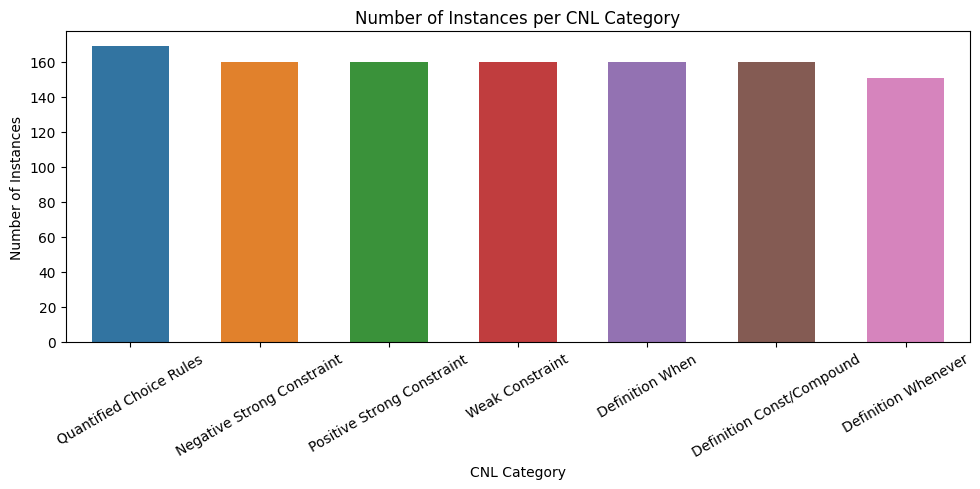

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the balanced dataset
balanced_df = pd.read_csv('Balanced_Dataset.csv')

# Count the number of instances in each category
category_counts = balanced_df['Category'].value_counts().reset_index()

# Rename columns for better readability
category_counts.columns = ['Category', 'Count']

# Create the bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Category', y='Count', data=category_counts, width=0.6)
plt.xticks(rotation=30)
plt.xlabel('CNL Category')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per CNL Category')
plt.tight_layout()

# Save the plot as an image file
plt.savefig('CNL_Category_Bar_Plot.png', dpi=300)

# Show the plot
plt.show()


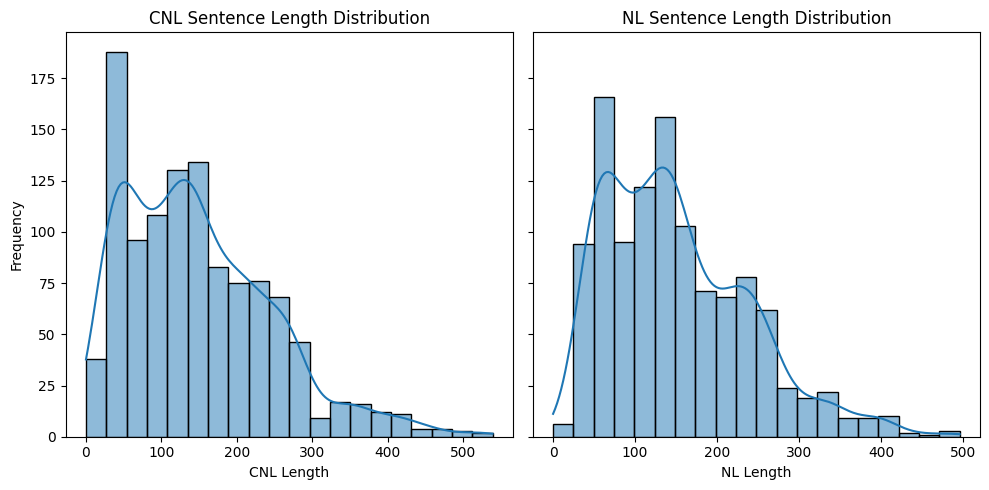

In [ ]:
# Calculate the length of NL and CNL sentences
balanced_df['CNL_length'] = balanced_df['CNL'].apply(lambda x: len(x) if isinstance(x, str) else 0)
balanced_df['NL_length'] = balanced_df['NL'].apply(lambda x: len(x) if isinstance(x, str) else 0)


# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# CNL length distribution
sns.histplot(data=balanced_df, x='CNL_length', kde=True, ax=axes[0], bins=20)
axes[0].set_title('CNL Sentence Length Distribution')
axes[0].set_xlabel('CNL Length')
axes[0].set_ylabel('Frequency')

# NL length distribution
sns.histplot(data=balanced_df, x='NL_length', kde=True, ax=axes[1], bins=20)
axes[1].set_title('NL Sentence Length Distribution')
axes[1].set_xlabel('NL Length')

plt.tight_layout()

# Save the plot as an image file
plt.savefig('Sentence_Length_Distributions.png', dpi=300)

# Show the plot
plt.show()
